In [1]:
using LinearRegression
using Statistics
using CairoMakie
using DelimitedFiles
using Megafauna
using Distances
using HypothesisTests
include("../src/SegmentDistances.jl")
include("../src/DPC.jl")

function identify_transitions(X, cps)
    N = length(cps) - 1
    t1, t2, t3, t4 = cps[1], cps[2], cps[3], cps[4]
    predecessor = X[t1:t2]
    current = X[t2:t3]
    successor = X[t3:t4]
    m_pred, σ_pred = median(predecessor), std(predecessor)
    m_curr, σ_curr = median(current), std(current)
    m_succ, σ_succ = median(successor), std(successor)
    transition_labels = zeros(N)
    for i = 2:N-2
        metalike = 0
        translike = 0
        L = length(current)
        for (idx, x) in enumerate(current)
            λ = idx / (L + 1)
            μ = λ * median(successor) + (1 - λ) * median(predecessor)
            ρ = λ * std(successor) + (1 - λ) * std(predecessor)
            metalike -= log(2* σ_curr) + (abs(x - m_curr) / σ_curr)
            translike -= log(2 * ρ) + (abs(x - μ) / ρ)
        end
        transition_labels[i] = metalike > translike ? 0 : 1
        if i == N -2
            break
        end
        predecessor = current
        current = successor
        successor = X[cps[i+2]:cps[i+3]]
        m_pred, σ_pred = m_curr, σ_curr
        m_curr, σ_curr = m_succ, σ_succ
        m_succ, σ_succ = median(successor), std(successor)
    end
    return transition_labels
end

identify_transitions (generic function with 1 method)

In [3]:
X = readdlm("../data/Langevin/langevin.txt")
#mf_cps = readdlm("../data/Langevin/moving_window_cps.txt", Int32)
windowsize = 225
mf_cps = compute_change_points(X, 0.85, windowsize)
mf_deriv = compute_metric_wasserstein_derivative(X, windowsize, sqeuclidean)[:,1]
bart_cps = convert(Array{Int32}, readdlm("../data/Langevin/lang_cps.txt"))
true_cps = convert(Array{Int32}, readdlm("../data/Langevin/langevin_change_point_ground_truth.txt"))
mf_cps[1] = 1
bart_cps[1] = 1
true_cps[1] = 1

bart_segment_transition_labels = identify_transitions(X, bart_cps);
bart_point_labels = label_series(X, bart_cps, bart_segment_transition_labels);
mf_segment_transition_labels = identify_transitions(X, mf_cps);
mf_point_labels = label_series(X, mf_cps, mf_segment_transition_labels);

N = length(bart_cps) - 1
laplace_pvalues = []
normal_pvalues = []
mstable_lengths = []
n_mstable = 0
for i=1:N
    if bart_segment_transition_labels[i] > 0
        continue
    end
    n_mstable += 1
    segment = X[bart_cps[i]:bart_cps[i+1]]
    push!(mstable_lengths, length(segment))
    Z = fit_mle(Laplace, segment)
    Zprime = fit_mle(Normal, segment)
    push!(laplace_pvalues, pvalue(ExactOneSampleKSTest(segment, Z)))
    push!(normal_pvalues, pvalue(ExactOneSampleKSTest(segment, Zprime)))
end
println("Number of metastable segments: $n_mstable")
println("Percentage of metastable segments that reject the Laplace hypothesis 
    $(1 - count(>(0.05), laplace_pvalues) / n_mstable))")
println("Median length of metsatsble segments $(median(mstable_lengths))")
println("IQR of length of metastable segments $(quantile(mstable_lengths, 0.75) - quantile(mstable_lengths, 0.25))")
println("Percentage of metastable segments that reject the Normal hypothesis 
    $(1 - (count(>(0.05), normal_pvalues)) / n_mstable )")

enumerating change points
number of dimensions: 1


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68


Number of metastable segments: 120
Percentage of metastable segments that reject the Laplace hypothesis 
    0.75)
Median length of metsatsble segments 532.0


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68


IQR of length of metastable segments 711.75
Percentage of metastable segments that reject the Normal hypothesis 
    0.5


In [ ]:
fig_size = (2000,800)
fig = Figure(size=fig_size)
cmap=Makie.Categorical(:darktest)

ax1 = Axis(fig[1,1])
ax2 = Axis(fig[2,1])
ax3 = Axis(fig[3,1])
ax1.title="Synthetic Langevin Trajectory Segmented via Megafauna"
ax2.title="Synthetic Langevin Trajectory Segmented via BarT"
ax1.xlabel=ax2.xlabel=ax3.xlabel="t"
ax1.ylabel=ax2.ylabel="x(t)"
ax1.xticks=ax2.xticks=ax3.xticks=0:5000:100000
ax1.xtickformat=ax2.xtickformat=ax3.xtickformat="{:.0f}"
ax1.yticks=ax2.yticks=-1:1:1

lines!(ax1, 1:100000, X[:,1], color=bart_point_labels, colormap=cmap)
vlines!(ax1,bart_cps[:,1], linestyle=:dashdot)
lines!(ax2, 1:100000, X[:,1], color=mf_point_labels, colormap=cmap)
vlines!(ax2,mf_cps[:,1], linestyle=:dashdot)
lines!(ax3, 1:100000, mf_deriv, color=mf_point_labels, colormap=cmap)
vlines!(ax3,mf_cps[:,1], linestyle=:dashdot)

fig
#save("clustered-langevin-$(K).png", fig)

current_figure()

In [5]:
N = length(mf_cps) - 1
pvalues = []
mstable_lengths = []
n_mstable = 0
for i=1:N
    if mf_segment_transition_labels[i] > 0
        continue
    end
    n_mstable += 1
    segment = X[mf_cps[i]:mf_cps[i+1]]
    push!(mstable_lengths, length(segment))
    Z = fit_mle(Normal, segment)
    push!(pvalues, pvalue(ExactOneSampleKSTest(segment, Z)))
end
println(n_mstable)
println(length(pvalues[pvalues .> 0.05]) / length(bart_segment_transition_labels[bart_segment_transition_labels .< 1]))
println(median(mstable_lengths))
println(quantile(mstable_lengths, 0.75) - quantile(mstable_lengths, 0.25))

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68


131
0.49166666666666664
218.0
805.0


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68


Conclusion: only a quarter of the metastable segments identified by BarT fail to reject the hypothesis that they were drawn from the distribution that MLE suggests they should be drawn from

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68


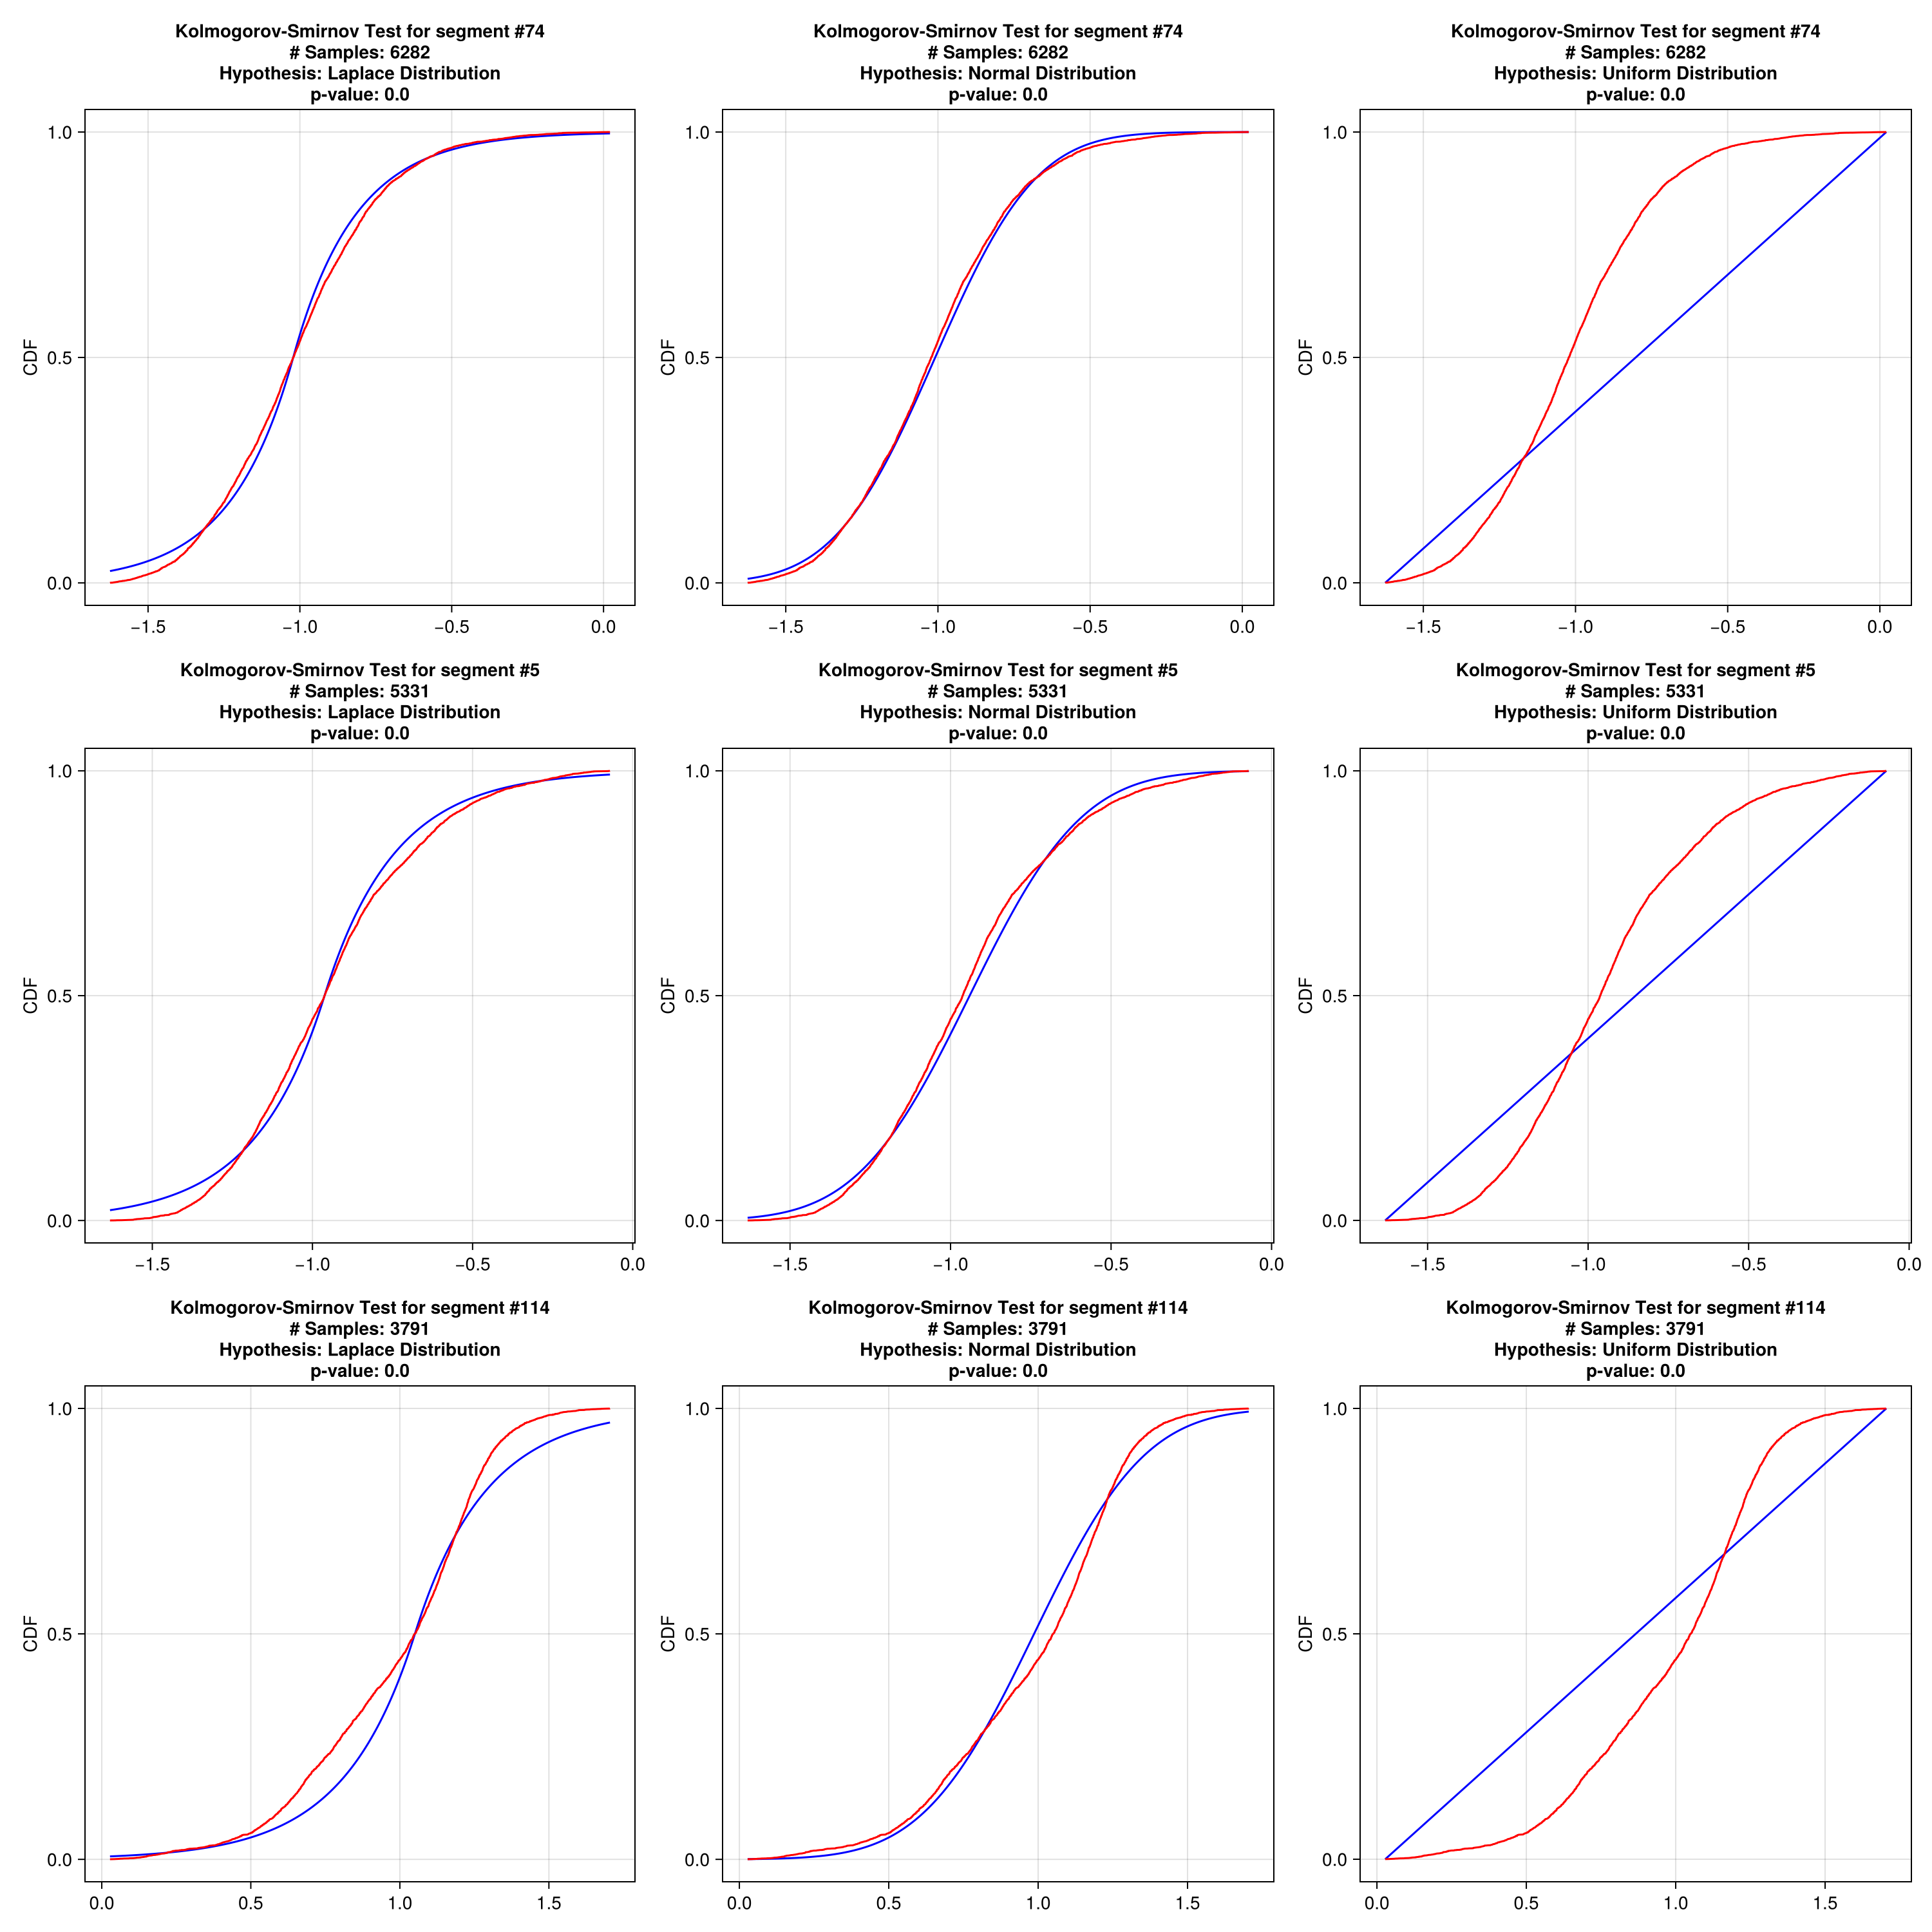

In [31]:
segment_lengths = [bart_cps[T+1] - bart_cps[T] for T in 1:length(bart_cps) - 1]
idx = sortperm(segment_lengths, rev=true);
fig = Figure(size=(1500, 1500))
for i = 1:3
T = idx[i]
segment = X[bart_cps[T]:bart_cps[T+1]]
U = fit_mle(Normal, segment)
V = fit_mle(Laplace, segment)
W = fit_mle(Uniform, segment)
Uks = ExactOneSampleKSTest(segment, U)
Vks = ExactOneSampleKSTest(segment, V)
Wks = ExactOneSampleKSTest(segment, W)
t = collect(range(minimum(segment), maximum(segment), length=1000))
ax = Axis(fig[i,1], title="Kolmogorov-Smirnov Test for segment #$(T)\n# Samples: $(length(segment))\nHypothesis: Laplace Distribution\np-value: $(round(pvalue(Vks),digits=3))", ylabel="CDF")
ax2 = Axis(fig[i,2], title="Kolmogorov-Smirnov Test for segment #$(T)\n# Samples: $(length(segment))\nHypothesis: Normal Distribution\np-value: $(round(pvalue(Uks),digits=3))", ylabel="CDF")
ax3 = Axis(fig[i,3], title="Kolmogorov-Smirnov Test for segment #$(T)\n# Samples: $(length(segment))\nHypothesis: Uniform Distribution\np-value: $(round(pvalue(Wks),digits=3))", ylabel="CDF")
lines!(ax, t, cdf.(V,t), color="blue")
lines!(ax, sort(segment), (1:length(segment))./length(segment),color="red")
lines!(ax2, t, cdf.(U,t), color="blue")
lines!(ax2, sort(segment), (1:length(segment))./length(segment),color="red")
lines!(ax3, t, cdf.(W,t), color="blue")
lines!(ax3, sort(segment), (1:length(segment))./length(segment),color="red")
end
current_figure()
#save("langevin-ks-test.png", fig)
#save("langevin-ks-test.pdf", fig)
